In [1]:
import pickle
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from pprint import pprint

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import MT5ForConditionalGeneration, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from datasets import load_dataset
from evaluate import load
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm 
from scipy.stats import kurtosis
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean
from scipy.stats import gmean
from evaluate import load
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import pickle
import matplotlib.pyplot as plt 
import evaluate
import torch
import time
import nltk
import numpy as np
import torch.nn.functional as F

nltk.download('wordnet')
bertscore = load("bertscore")

/Users/jinhyunpark/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jinhyunpark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
with open("training/score_collector_en_de_small.pkl", "rb") as file:
    score_collector_en_de_small = pickle.load(file)

with open("training/score_collector_en_fr_small.pkl", "rb") as file:
    score_collector_en_fr_small = pickle.load(file)

with open("training/score_collector_en_ro_small.pkl", "rb") as file:
    score_collector_en_ro_small = pickle.load(file)

In [4]:
with open("training/score_collector_en_de_base.pkl", "rb") as file:
    score_collector_en_de_base = pickle.load(file)

with open("training/score_collector_en_fr_base.pkl", "rb") as file:
    score_collector_en_fr_base = pickle.load(file)

with open("training/score_collector_en_ro_base.pkl", "rb") as file:
    score_collector_en_ro_base = pickle.load(file)

### Additional Experiments

In [5]:
print("[small]")
t5_tokenizer_small = AutoTokenizer.from_pretrained('t5-small')
t5_model_small = AutoModelForSeq2SeqLM.from_pretrained('t5-small')

print(f"Vocabulary Size: {t5_tokenizer_small.vocab_size}")
param_count = sum(p.numel() for p in t5_model_small.parameters())
print(f"Parameter Size: {param_count} parameters")

print("[base]")
t5_tokenizer_base = AutoTokenizer.from_pretrained('t5-base')
t5_model_base = AutoModelForSeq2SeqLM.from_pretrained('t5-base')

print(f"Vocabulary Size: {t5_tokenizer_base.vocab_size}")
param_count = sum(p.numel() for p in t5_model_base.parameters())
print(f"Parameter Size: {param_count} parameters")

print("[large]")
t5_tokenizer_large = AutoTokenizer.from_pretrained('t5-large')
t5_model_large = AutoModelForSeq2SeqLM.from_pretrained('t5-large')

print(f"Vocabulary Size: {t5_tokenizer_large.vocab_size}")
param_count = sum(p.numel() for p in t5_model_large.parameters())
print(f"Parameter Size: {param_count} parameters")


[small]
Vocabulary Size: 32100
Parameter Size: 60506624 parameters
[base]
Vocabulary Size: 32100
Parameter Size: 222903552 parameters
[large]
Vocabulary Size: 32100
Parameter Size: 737668096 parameters


### EN-DE

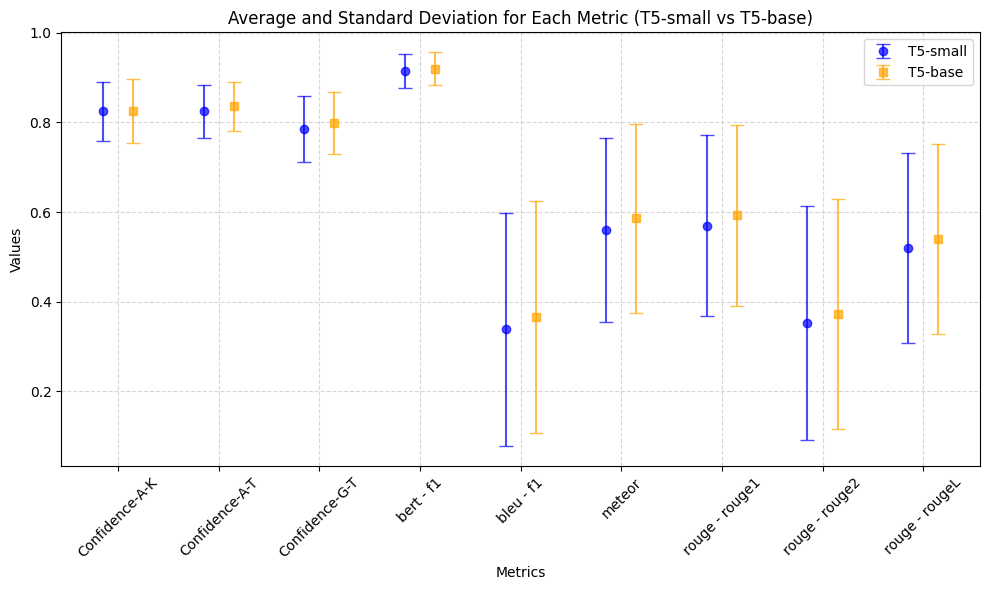

In [6]:
results_small = {
    "Confidence-A-K": (np.mean(score_collector_en_de_small["Confidence-A-K"]), np.std(score_collector_en_de_small["Confidence-A-K"])),
    "Confidence-A-T": (np.mean(score_collector_en_de_small["Confidence-A-T"]), np.std(score_collector_en_de_small["Confidence-A-T"])),
    "Confidence-G-T": (np.mean(score_collector_en_de_small["Confidence-G-T"]), np.std(score_collector_en_de_small["Confidence-G-T"])),
    "bert - f1": (np.mean([item["f1"][0] for item in score_collector_en_de_small["bert"]]), np.std([item["f1"][0] for item in score_collector_en_de_small["bert"]])),
    "bleu - f1": (np.mean(score_collector_en_de_small["bleu"]), np.std(score_collector_en_de_small["bleu"])),
    "meteor": (np.mean(score_collector_en_de_small["meteor"]), np.std(score_collector_en_de_small["meteor"])),
    "rouge - rouge1": (np.mean([item["rouge1"] for item in score_collector_en_de_small["rouge"]]), np.std([item["rouge1"] for item in score_collector_en_de_small["rouge"]])),
    "rouge - rouge2": (np.mean([item["rouge2"] for item in score_collector_en_de_small["rouge"]]), np.std([item["rouge2"] for item in score_collector_en_de_small["rouge"]])),
    "rouge - rougeL": (np.mean([item["rougeL"] for item in score_collector_en_de_small["rouge"]]), np.std([item["rougeL"] for item in score_collector_en_de_small["rouge"]])),
}

results_base = {
    "Confidence-A-K": (np.mean(score_collector_en_de_base["Confidence-A-K"]), np.std(score_collector_en_de_base["Confidence-A-K"])),
    "Confidence-A-T": (np.mean(score_collector_en_de_base["Confidence-A-T"]), np.std(score_collector_en_de_base["Confidence-A-T"])),
    "Confidence-G-T": (np.mean(score_collector_en_de_base["Confidence-G-T"]), np.std(score_collector_en_de_base["Confidence-G-T"])),
    "bert - f1": (np.mean([item["f1"][0] for item in score_collector_en_de_base["bert"]]), np.std([item["f1"][0] for item in score_collector_en_de_base["bert"]])),
    "bleu - f1": (np.mean(score_collector_en_de_base["bleu"]), np.std(score_collector_en_de_base["bleu"])),
    "meteor": (np.mean(score_collector_en_de_base["meteor"]), np.std(score_collector_en_de_base["meteor"])),
    "rouge - rouge1": (np.mean([item["rouge1"] for item in score_collector_en_de_base["rouge"]]), np.std([item["rouge1"] for item in score_collector_en_de_base["rouge"]])),
    "rouge - rouge2": (np.mean([item["rouge2"] for item in score_collector_en_de_base["rouge"]]), np.std([item["rouge2"] for item in score_collector_en_de_base["rouge"]])),
    "rouge - rougeL": (np.mean([item["rougeL"] for item in score_collector_en_de_base["rouge"]]), np.std([item["rougeL"] for item in score_collector_en_de_base["rouge"]])),
}

small = pd.DataFrame(results_small, index=["Average", "Standard Deviation"]).T
base = pd.DataFrame(results_base, index=["Average", "Standard Deviation"]).T

metrics_small  = small.index
averages_small = small["Average"]
std_devs_small = small["Standard Deviation"]

metrics_base  = base.index
averages_base = base["Average"]
std_devs_base = base["Standard Deviation"]

plt.figure(figsize=(10, 6))
x_shift_small = np.arange(len(metrics_small)) - 0.15  # Left shift for T5-small
x_shift_base  = np.arange(len(metrics_base))  + 0.15   # Right shift for T5-base

plt.errorbar(x_shift_small, averages_small, yerr=std_devs_small, fmt='o', capsize=5, label="T5-small", alpha=0.7, color='blue')
plt.errorbar(x_shift_base,  averages_base,  yerr=std_devs_base,  fmt='s', capsize=5, label="T5-base", alpha=0.7,  color='orange')

plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Average and Standard Deviation for Each Metric (T5-small vs T5-base)")
plt.xticks(np.arange(len(metrics_small)), metrics_small, rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### EN-FR

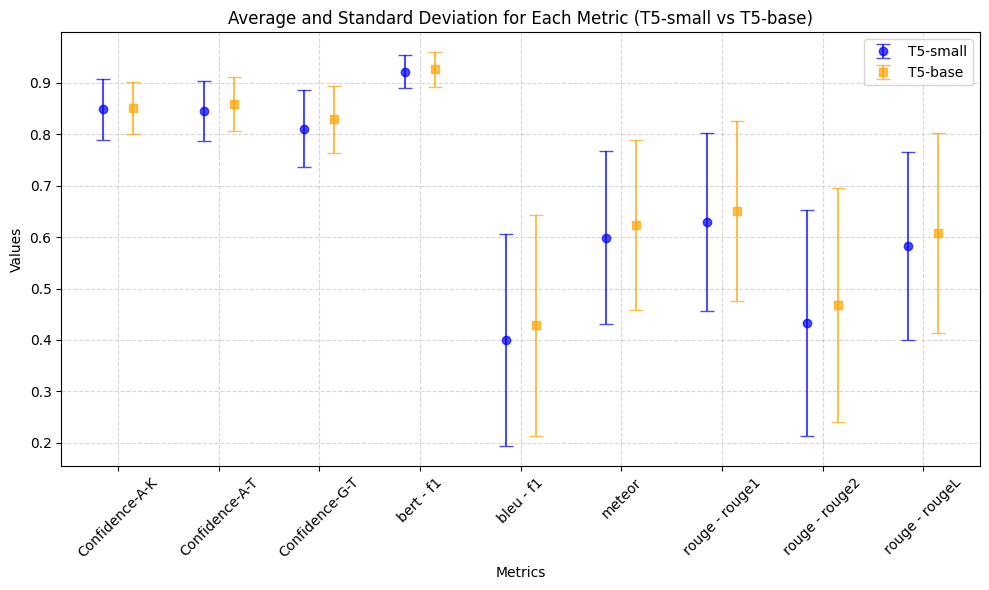

In [7]:
results_small = {
    "Confidence-A-K": (np.mean(score_collector_en_fr_small["Confidence-A-K"]), np.std(score_collector_en_fr_small["Confidence-A-K"])),
    "Confidence-A-T": (np.mean(score_collector_en_fr_small["Confidence-A-T"]), np.std(score_collector_en_fr_small["Confidence-A-T"])),
    "Confidence-G-T": (np.mean(score_collector_en_fr_small["Confidence-G-T"]), np.std(score_collector_en_fr_small["Confidence-G-T"])),
    "bert - f1": (np.mean([item["f1"][0] for item in score_collector_en_fr_small["bert"]]), np.std([item["f1"][0] for item in score_collector_en_fr_small["bert"]])),
    "bleu - f1": (np.mean(score_collector_en_fr_small["bleu"]), np.std(score_collector_en_fr_small["bleu"])),
    "meteor": (np.mean(score_collector_en_fr_small["meteor"]), np.std(score_collector_en_fr_small["meteor"])),
    "rouge - rouge1": (np.mean([item["rouge1"] for item in score_collector_en_fr_small["rouge"]]), np.std([item["rouge1"] for item in score_collector_en_fr_small["rouge"]])),
    "rouge - rouge2": (np.mean([item["rouge2"] for item in score_collector_en_fr_small["rouge"]]), np.std([item["rouge2"] for item in score_collector_en_fr_small["rouge"]])),
    "rouge - rougeL": (np.mean([item["rougeL"] for item in score_collector_en_fr_small["rouge"]]), np.std([item["rougeL"] for item in score_collector_en_fr_small["rouge"]])),
}

results_base = {
    "Confidence-A-K": (np.mean(score_collector_en_fr_base["Confidence-A-K"]), np.std(score_collector_en_fr_base["Confidence-A-K"])),
    "Confidence-A-T": (np.mean(score_collector_en_fr_base["Confidence-A-T"]), np.std(score_collector_en_fr_base["Confidence-A-T"])),
    "Confidence-G-T": (np.mean(score_collector_en_fr_base["Confidence-G-T"]), np.std(score_collector_en_fr_base["Confidence-G-T"])),
    "bert - f1": (np.mean([item["f1"][0] for item in score_collector_en_fr_base["bert"]]), np.std([item["f1"][0] for item in score_collector_en_fr_base["bert"]])),
    "bleu - f1": (np.mean(score_collector_en_fr_base["bleu"]), np.std(score_collector_en_fr_base["bleu"])),
    "meteor": (np.mean(score_collector_en_fr_base["meteor"]), np.std(score_collector_en_fr_base["meteor"])),
    "rouge - rouge1": (np.mean([item["rouge1"] for item in score_collector_en_fr_base["rouge"]]), np.std([item["rouge1"] for item in score_collector_en_fr_base["rouge"]])),
    "rouge - rouge2": (np.mean([item["rouge2"] for item in score_collector_en_fr_base["rouge"]]), np.std([item["rouge2"] for item in score_collector_en_fr_base["rouge"]])),
    "rouge - rougeL": (np.mean([item["rougeL"] for item in score_collector_en_fr_base["rouge"]]), np.std([item["rougeL"] for item in score_collector_en_fr_base["rouge"]])),
}

small = pd.DataFrame(results_small, index=["Average", "Standard Deviation"]).T
base = pd.DataFrame(results_base, index=["Average", "Standard Deviation"]).T

metrics_small  = small.index
averages_small = small["Average"]
std_devs_small = small["Standard Deviation"]

metrics_base  = base.index
averages_base = base["Average"]
std_devs_base = base["Standard Deviation"]

plt.figure(figsize=(10, 6))
x_shift_small = np.arange(len(metrics_small)) - 0.15  # Left shift for T5-small
x_shift_base  = np.arange(len(metrics_base))  + 0.15   # Right shift for T5-base

plt.errorbar(x_shift_small, averages_small, yerr=std_devs_small, fmt='o', capsize=5, label="T5-small", alpha=0.7, color='blue')
plt.errorbar(x_shift_base,  averages_base,  yerr=std_devs_base,  fmt='s', capsize=5, label="T5-base", alpha=0.7,  color='orange')

plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Average and Standard Deviation for Each Metric (T5-small vs T5-base)")
plt.xticks(np.arange(len(metrics_small)), metrics_small, rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### EN-RO

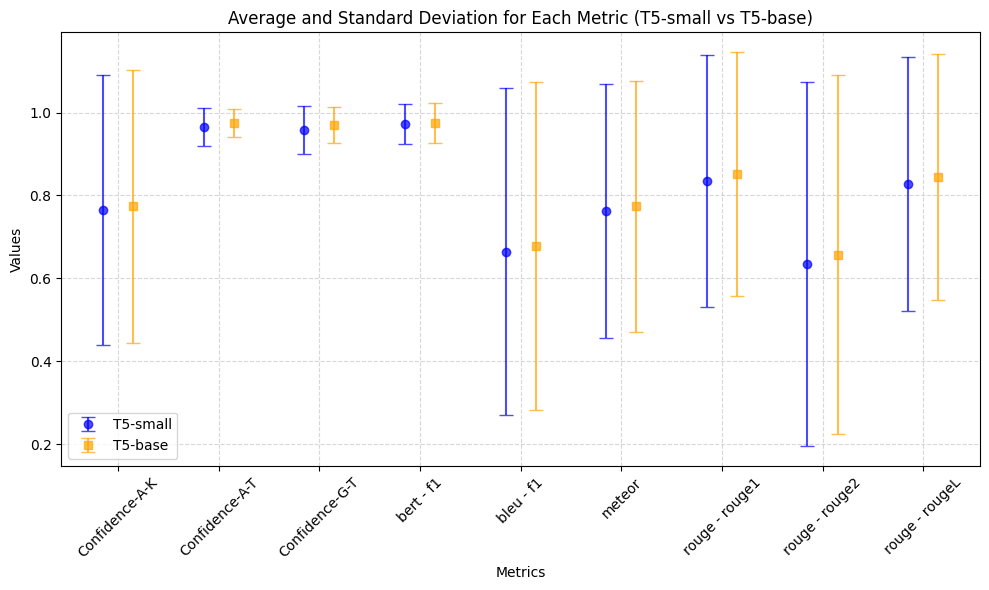

In [8]:
results_small = {
    "Confidence-A-K": (np.mean(score_collector_en_ro_small["Confidence-A-K"]), np.std(score_collector_en_ro_small["Confidence-A-K"])),
    "Confidence-A-T": (np.mean(score_collector_en_ro_small["Confidence-A-T"]), np.std(score_collector_en_ro_small["Confidence-A-T"])),
    "Confidence-G-T": (np.mean(score_collector_en_ro_small["Confidence-G-T"]), np.std(score_collector_en_ro_small["Confidence-G-T"])),
    "bert - f1": (np.mean([item["f1"][0] for item in score_collector_en_ro_small["bert"]]), np.std([item["f1"][0] for item in score_collector_en_ro_small["bert"]])),
    "bleu - f1": (np.mean(score_collector_en_ro_small["bleu"]), np.std(score_collector_en_ro_small["bleu"])),
    "meteor": (np.mean(score_collector_en_ro_small["meteor"]), np.std(score_collector_en_ro_small["meteor"])),
    "rouge - rouge1": (np.mean([item["rouge1"] for item in score_collector_en_ro_small["rouge"]]), np.std([item["rouge1"] for item in score_collector_en_ro_small["rouge"]])),
    "rouge - rouge2": (np.mean([item["rouge2"] for item in score_collector_en_ro_small["rouge"]]), np.std([item["rouge2"] for item in score_collector_en_ro_small["rouge"]])),
    "rouge - rougeL": (np.mean([item["rougeL"] for item in score_collector_en_ro_small["rouge"]]), np.std([item["rougeL"] for item in score_collector_en_ro_small["rouge"]])),
}

results_base = {
    "Confidence-A-K": (np.mean(score_collector_en_ro_base["Confidence-A-K"]), np.std(score_collector_en_ro_base["Confidence-A-K"])),
    "Confidence-A-T": (np.mean(score_collector_en_ro_base["Confidence-A-T"]), np.std(score_collector_en_ro_base["Confidence-A-T"])),
    "Confidence-G-T": (np.mean(score_collector_en_ro_base["Confidence-G-T"]), np.std(score_collector_en_ro_base["Confidence-G-T"])),
    "bert - f1": (np.mean([item["f1"][0] for item in score_collector_en_ro_base["bert"]]), np.std([item["f1"][0] for item in score_collector_en_ro_base["bert"]])),
    "bleu - f1": (np.mean(score_collector_en_ro_base["bleu"]), np.std(score_collector_en_ro_base["bleu"])),
    "meteor": (np.mean(score_collector_en_ro_base["meteor"]), np.std(score_collector_en_ro_base["meteor"])),
    "rouge - rouge1": (np.mean([item["rouge1"] for item in score_collector_en_ro_base["rouge"]]), np.std([item["rouge1"] for item in score_collector_en_ro_base["rouge"]])),
    "rouge - rouge2": (np.mean([item["rouge2"] for item in score_collector_en_ro_base["rouge"]]), np.std([item["rouge2"] for item in score_collector_en_ro_base["rouge"]])),
    "rouge - rougeL": (np.mean([item["rougeL"] for item in score_collector_en_ro_base["rouge"]]), np.std([item["rougeL"] for item in score_collector_en_ro_base["rouge"]])),
}

small = pd.DataFrame(results_small, index=["Average", "Standard Deviation"]).T
base = pd.DataFrame(results_base, index=["Average", "Standard Deviation"]).T

metrics_small  = small.index
averages_small = small["Average"]
std_devs_small = small["Standard Deviation"]

metrics_base  = base.index
averages_base = base["Average"]
std_devs_base = base["Standard Deviation"]

plt.figure(figsize=(10, 6))
x_shift_small = np.arange(len(metrics_small)) - 0.15  # Left shift for T5-small
x_shift_base  = np.arange(len(metrics_base))  + 0.15   # Right shift for T5-base

plt.errorbar(x_shift_small, averages_small, yerr=std_devs_small, fmt='o', capsize=5, label="T5-small", alpha=0.7, color='blue')
plt.errorbar(x_shift_base,  averages_base,  yerr=std_devs_base,  fmt='s', capsize=5, label="T5-base", alpha=0.7,  color='orange')

plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Average and Standard Deviation for Each Metric (T5-small vs T5-base)")
plt.xticks(np.arange(len(metrics_small)), metrics_small, rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
